In [1]:
import numpy as np
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, ZScaleInterval
from keras.applications.vgg16 import VGG16
# example of using a pre-trained model as a classifier
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import tensorflow as tf
import segmentation_models_pytorch as smp
from torchvision import models
from matplotlib.pyplot import cm
from os import listdir
from skimage.util.shape import view_as_windows
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Apply the transformations needed
import torchvision.transforms as T
import seaborn as sns
import cv2

In [2]:
import sys
sys.path.append("..")
from medzoo_imports import create_model, DiceLoss, Trainer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from data_generators.data_loader import SegmentationDataSet
import argparse
from os import listdir
import os
import shutil

In [3]:
batch_size=4
dataset_name="hi_data"
root = '../data/testing/'
dim=(64, 64, 64)
nEpochs=10
classes=2
inChannels=1
terminal_show_freq=50
split=0.
model='VNET'
opt='sgd'
log_dir='../runs/'
lr = 1e-2
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}

save = ('../saved_models/' + model + '_checkpoints/' + model + '_', dataset_name)[0]
# input and target files
inputs = [root+x for x in listdir(root) if "loud_" in x and x.endswith(".fits")]
targets = [root+x for x in listdir(root) if "mask_" in x and x.endswith(".fits")]
random_seed = 42
train_size = 0.8
dims = [128, 128, 64]
overlaps = np.array(dims)-np.array([100, 100, 42])
inputs, targets

(['../data/testing/loud_1245mosC.fits', '../data/testing/loud_1245mosB.fits'],
 ['../data/testing/mask_1245mosC.fits', '../data/testing/mask_1245mosB.fits'])

In [5]:
inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

In [6]:
# dataset training
dataset_train = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    dims=dims,
                                    overlaps=overlaps,
                                    load=False,
                                    root=root)

# dataset validation
dataset_valid = SegmentationDataSet(inputs=inputs_valid,
                                    targets=targets_valid,
                                    dims=dims,
                                    overlaps=overlaps,
                                    load=False,
                                    root=root)


 3.989769820971867545

OSError: problem writing element 762880 to file

In [ ]:
# dataloader training
params = {'batch_size': batch_size,
        'shuffle': True,
        'num_workers': 2}
dataloader_training = DataLoader(dataset=dataset_train, **params)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, **params)

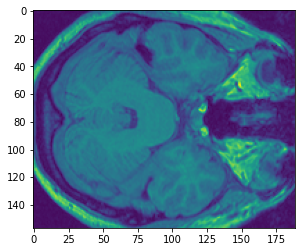

0


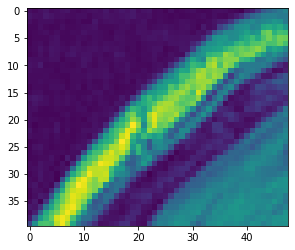

1


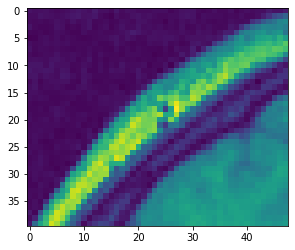

2


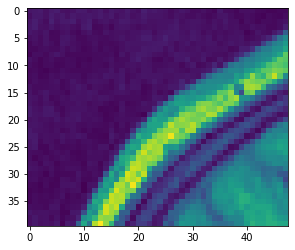

3


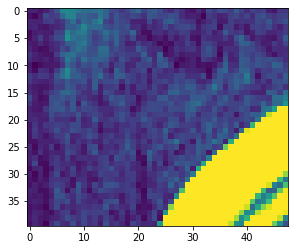

4


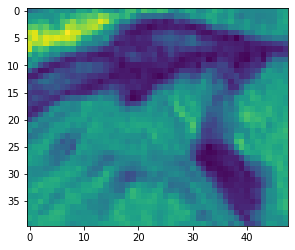

5


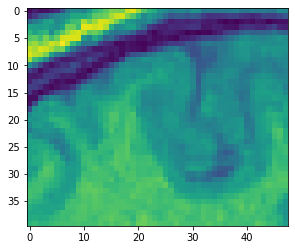

6


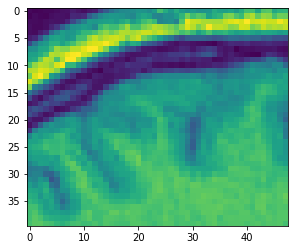

7


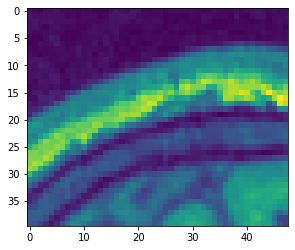

8


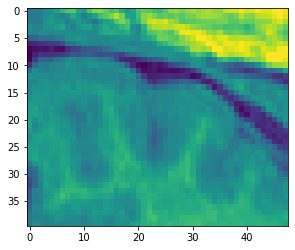

9


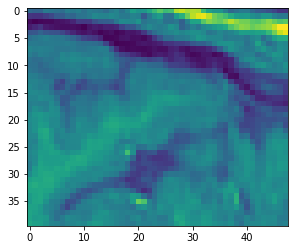

10


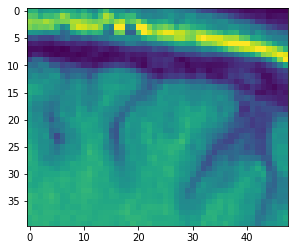

11


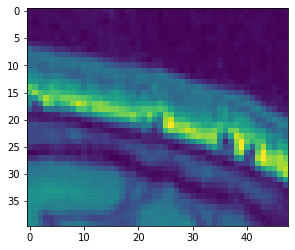

12


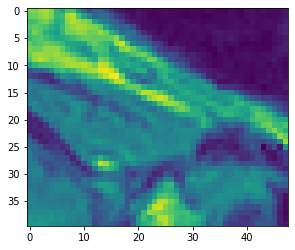

13


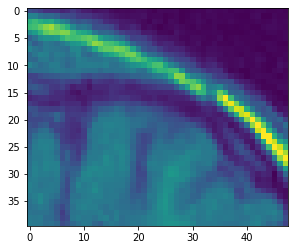

14


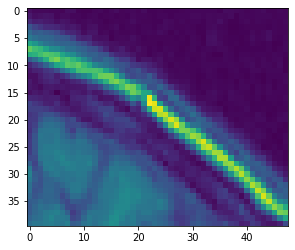

15


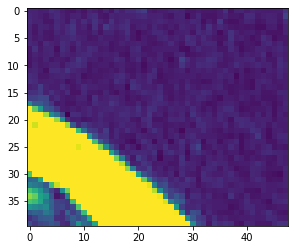

16


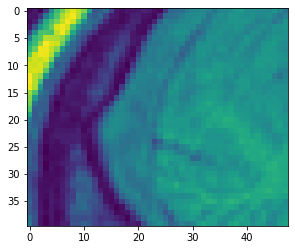

17


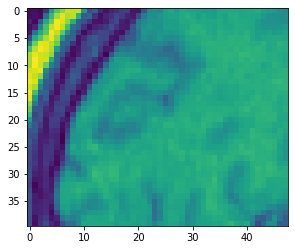

18


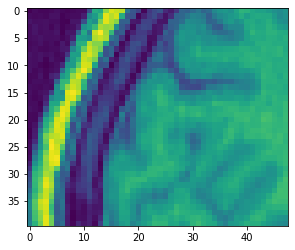

19


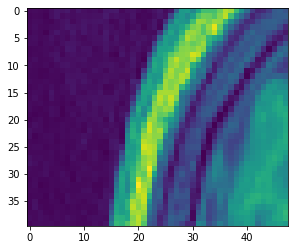

20


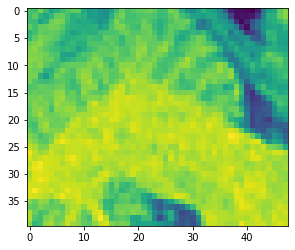

21


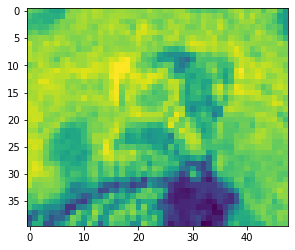

22


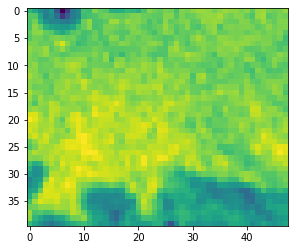

23


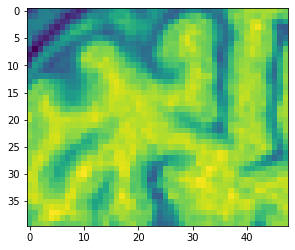

24


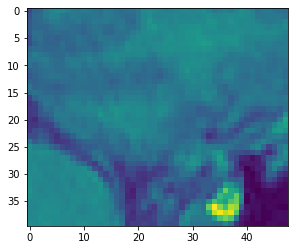

25


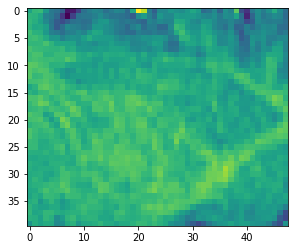

26


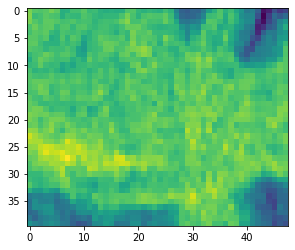

27


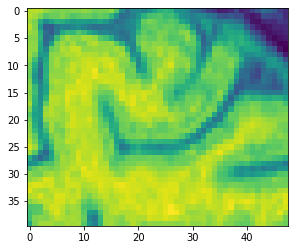

28


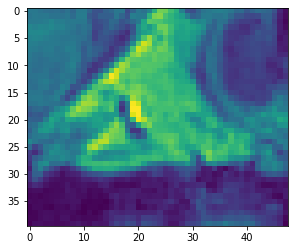

29


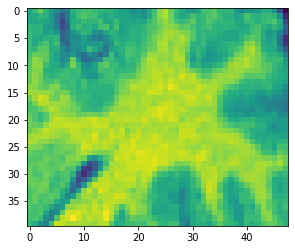

30


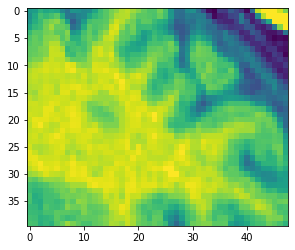

31


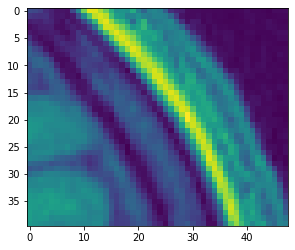

32


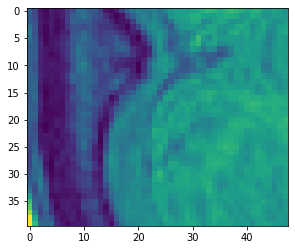

33


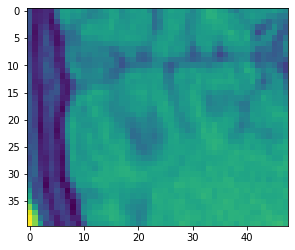

34


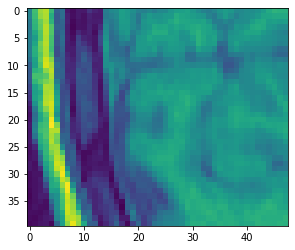

35


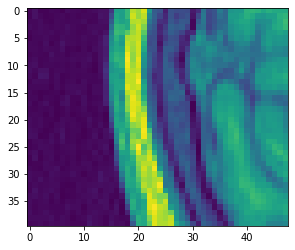

36


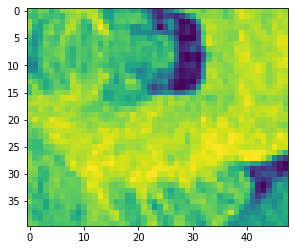

37


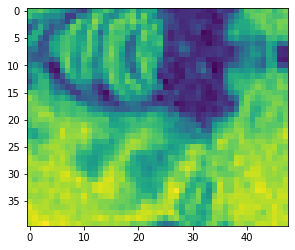

38


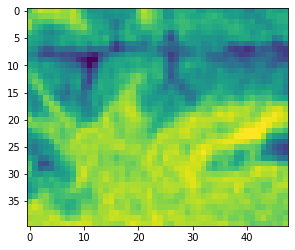

39


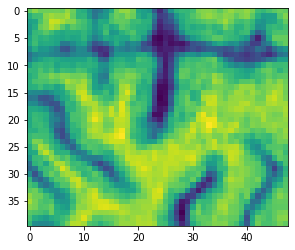

40


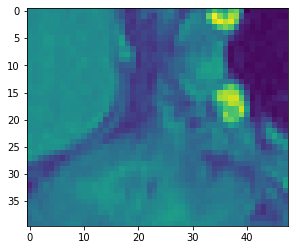

41


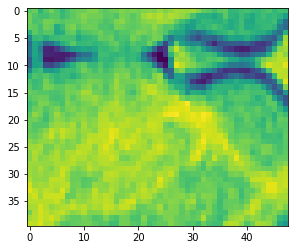

42


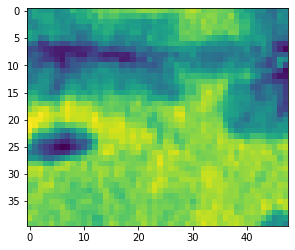

43


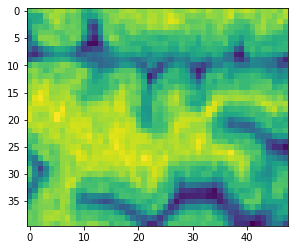

44


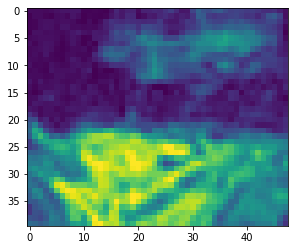

45


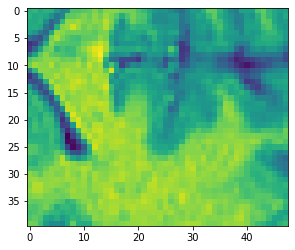

46


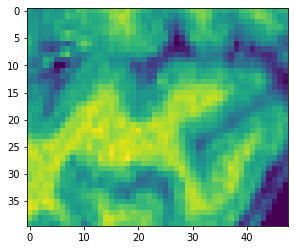

47


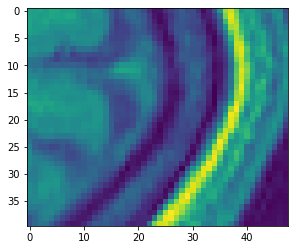

48


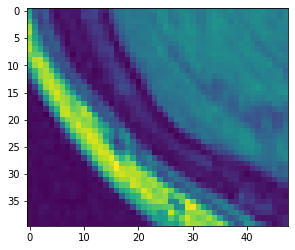

49


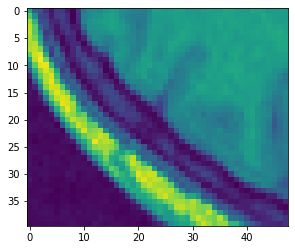

50


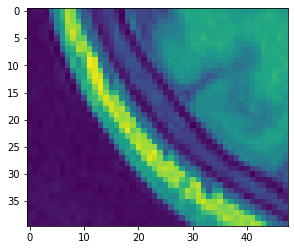

51


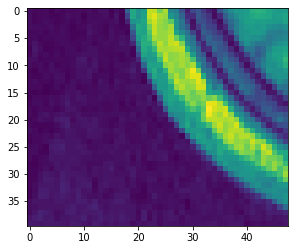

52


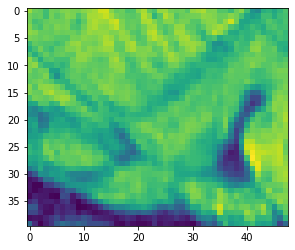

53


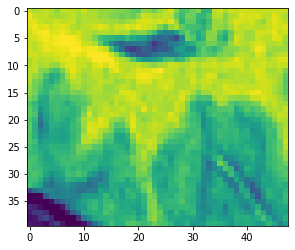

54


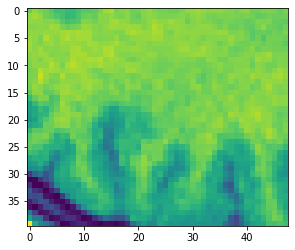

55


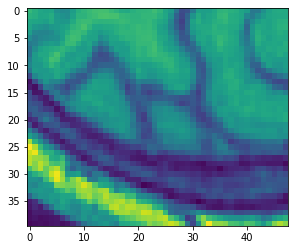

56


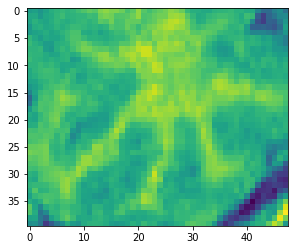

57


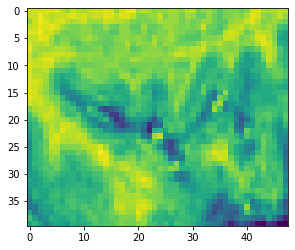

58


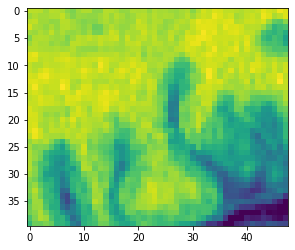

59


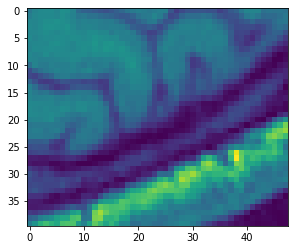

60


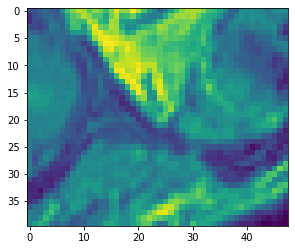

61


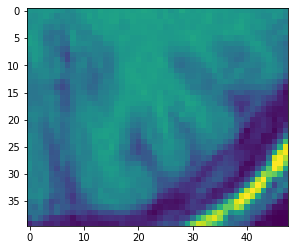

62


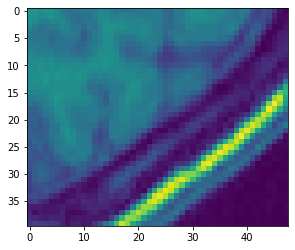

63


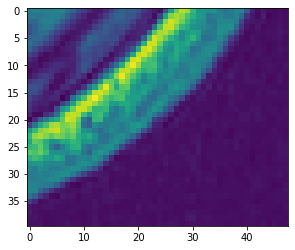

In [61]:
# import nibabel as nib
# img = nib.load("nsM00587_0002.img").get_fdata()
# plt.imshow(img[..., 10])
# plt.show()
# arr_out = view_as_windows(img, kernel, np.array([40, 48, 17])-np.array([5, 5, 2]))
# x,y,z = arr_out.shape[:3]
# interval = ZScaleInterval()
# count = 0
# for i in range(x):
#     for j in range(y):
#         for k in range(z):
#             print(count)
#             subcube = arr_out[i, j, k, :, :, :]
#             no_nans = np.nan_to_num(subcube)
#             # Z scale normalise between 0 and 1  
#             x = interval(no_nans)
#             plt.imshow(x[..., 10])
#             plt.show()
#             count += 1

In [ ]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=1
        self.log_dir = "./runs/"
        self.dataset_name = 'iseg2017'
        self.save = save
        self.terminal_show_freq = 50
        self.nEpochs = 10
        self.inModalities = 1
        self.cuda = False
args = argsclass('VNET', opt, lr, inChannels, classes)
model, optimizer = create_model(args)
criterion = DiceLoss(classes=args.classes)
if os.path.exists(save):
    shutil.rmtree(save)
    os.mkdir(save)
else:
    os.makedirs(save)

In [ ]:
trainer = Trainer(args, model, criterion, optimizer, train_data_loader=dataloader_training,
                        valid_data_loader=dataloader_validation, lr_scheduler=None)

In [ ]:
for input_tuple in trainer.train_data_loader:
    input_tensor, target = input_tuple
    output = trainer.model(input_tensor)
    break

In [ ]:
print("START TRAINING...")
trainer.training()

# Test sliding window

In [ ]:
cube_hdulist = fits.open("../data/training/Input/noisefree_1245mosC.fits")
cube_data = cube_hdulist[0].data
cube_hdulist.close()

maskcube_hdulist = fits.open("../data/training/Target/mask_1245mosC.fits")
maskcube_data = maskcube_hdulist[0].data
maskcube_hdulist.close()

In [ ]:
plt.imshow(cube_data[300, :, :])
plt.show()
plt.imshow(maskcube_data[300, :, :])
plt.show()

## Implement sliding window
From the closest distance (max frequency), figure out largest width of a galaxy cube = (42, 100, 100)

In [ ]:
import sys
sys.path.append("..")
from data_generators.cube_functions import *

In [ ]:
orig_d = 50*u.Mpc
h_0 = 70*u.km/(u.Mpc*u.s)
noise_res = [15*u.arcsec, 25*u.arcsec]
# Load Galaxy
orig_mass, dx, dy, dF, rest_freq, orig_scale, gal_data = load_cube('../data/mock_gals/model1000s.fits', orig_d, h_0)
# Choose max channel
chosen_f = (rest_freq/(1+orig_d*h_0/const.c)).to(u.Hz)
new_z = (rest_freq/chosen_f)-1
new_dist = (const.c*new_z/h_0).to(u.Mpc)
# chosen_f = , new_z, new_dist, z_pos = choose_freq(
#     noise_spectral, noise_data.shape, gal_data.shape, rest_freq, h_0, orig_d)
# Smooth cube
smoothed_gal = smooth_cube(noise_res, new_z, new_dist, dx, dy, gal_data, orig_scale)

In [ ]:
hdulist = fits.open("../data/mosaics/1245mosC.derip.fits")
noise_header = hdulist[0].header
hdulist.close()
# Regrid Cube
resampled, new_dF = regrid_cube(smoothed_gal, noise_header, new_dist, dx, dy, dF, orig_scale, chosen_f, rest_freq)

In [ ]:
print("Minimum overlap width = ", resampled.shape)

In [ ]:
masked_bin = (resampled > np.mean(resampled) + np.std(resampled)).astype(int)

In [ ]:
for i in range (44, 86):
    plt.imshow(masked_bin[i, 150:250, 150:250])
    plt.show()

In [ ]:
86-44, 100, 100

Need 128 × 128 × 64

In [ ]:
dims = [10, 500, 500]
overlaps = [8, 400, 400]

In [ ]:
kernel=(1, dims[0], dims[1], dims[2], 1)
stride=(1, overlaps[0], overlaps[1], overlaps[2], 1)    
patches=tf.extract_volume_patches(
    cube_data[280:300][None, ..., None],kernel,stride,'SAME',
)
_,x,y,z,n = patches.shape
_,sx,sy,sz,_ = kernel
patches = tf.reshape(patches,[x*y*z,sx,sy,sz])
patches.shape

In [ ]:
for i in range(1, len(patches)):
    plt.imshow(patches[i][0, :, :])
    plt.show()